# Tarea 1: DS Lab
- Ricardo Arancibia
- José Díaz
- Javier Santibáñez

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## P1

## P2

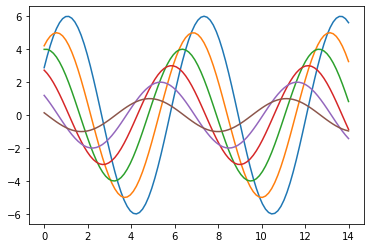

In [5]:
def sinplot(flip=1):
    x = np.linspace(0, 14, 100)
    for i in range(1, 7):
        plt.plot(x, np.sin(x + i * .5) * (7 - i) * flip)
sinplot()

In [15]:
def estilo(sty = "whitegrid"):
    param = {'axes.facecolor': 'white',
             'axes.edgecolor': 'black',
             'axes.grid': True,
             'axes.axisbelow': 'line',
             'axes.labelcolor': 'black',
             'figure.facecolor': (1, 1, 1, 0),
             'grid.color': '#b0b0b0',
             'grid.linestyle': '-',
             'text.color': 'black',
             'xtick.color': 'red',
             'ytick.color': 'black',
             'xtick.direction': 'out',
             'ytick.direction': 'out',
             'lines.solid_capstyle': 'projecting',
             'patch.edgecolor': 'black',
             'image.cmap': 'viridis',
             'font.family': ['sans-serif'],
             'font.sans-serif': ['DejaVu Sans',
             'Bitstream Vera Sans',
             'Computer Modern Sans Serif',
             'Lucida Grande',
             'Verdana',
             'Geneva',
             'Lucid',
             'Arial',
             'Helvetica',
             'Avant Garde',
             'sans-serif'],
             'patch.force_edgecolor': False,
             'xtick.bottom': True,
             'xtick.top': False,
             'ytick.left': True,
             'ytick.right': False,
             'axes.spines.left': True,
             'axes.spines.bottom': True,
             'axes.spines.right': False,
             'axes.spines.top': False}
    sns.set_style(sty, param)

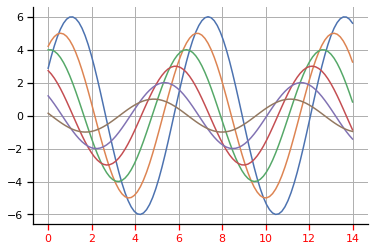

In [16]:
estilo()
sinplot()

## P3

In [8]:
from sklearn.base import BaseEstimator, RegressorMixin

In [22]:
# 1
class RegresionBayesianaEmpirica(BaseEstimator, RegressorMixin):

    def __init__(self, alpha_0, beta_0, tol=1e-5, maxiter=200):
        self.alpha_0 = alpha_0
        self.beta_0 = beta_0
        self.tol = tol
        self.maxiter = maxiter

    def get_posteriori(self, X, y, alpha, beta):
        N,d = X.shape
        S_N_1 = np.linalg.inv(alpha*np.identity(d) + beta*(X.T @ X))
        S_N = np.linalg.inv(S_N_1)
        m_N = beta*((S_N @ X.T) @ y)
        return m_N, S_N

    def fit(self, X, y):
        N,d = X.shape
        print('Iteracion: 1')
        lambdas, vectores = np.linalg.eig(self.beta_0*(X.T @ X))
        gamma = np.sum(lambdas/(self.alpha_0 + lambdas))
        m_N, S_N = self.get_posteriori(X,y,self.alpha_0,self.beta_0)
        alpha = gamma/(m_N.T @ m_N)
        la_suma = 0
        for i in range(N):
            la_suma += (y[i] - m_N.T@X[i])**2
        beta = (N-gamma)*(1/la_suma)

        for k in range(2, len(self.maxiter)+1):
            if (abs(self.alpha_0 - alpha) < self.tol) and (abs(self.beta_0 - beta) < self.tol):
                self.alpha_0 = alpha
                self.beta_0 = beta
                break
            else:
                print('Iteracion: ', k)
                self.alpha_0 = alpha
                self.beta_0 = beta
                lambdas, vectores = np.linalg.eig(self.beta_0*(X.T @ X))
                gamma = np.sum(lambdas/(self.alpha_0 + lambdas))
                m_N, S_N = self.get_posteriori(X,y,self.alpha_0,self.beta_0)
                alpha = gamma/(m_N.T @ m_N)
                la_suma = 0
                for i in range(N):
                    la_suma += (y[i] - m_N.T@X[i])**2
                beta = (N-gamma)*(1/la_suma)
        self.m_N = m_N
        self.S_N = S_N

    def predict(self, X_, return_std=False):
        y_ = X_ @ self.m_N
        y_std = 1/self.beta_0 + np.diag((X_ @ self.S_N) @ X_.T)
        if return_std:
            return y_, y_std
        else:
            return y_    